## StatQuest!
# Support Vector Machines in Python, From Start To Finish
Copyright 2020, Joshua Starmer

----

In this lesson we will build a **Support Vector Machine** for **classification** using **scikit-learn** and the **Radial Basis Function (RBF) Kernel**. Our training data set contains continuous and categorical data from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)** to predict whether or not a person will **[default on their credit card](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)**.

<img src="svm_default.png" alt="A Support Vector Machine" style="width: 600px;">

**Support Vector Machines** are one of the best machine learning methods when getting the correct answer is a higher priorty than understanding why you get the correct answer. They work really well with relatively small datasets and they tend to work well "out of the box". In other words, they do not require much optimization.

In this lesson you will learn about...

- **[Importing Data from a File](#download-the-data)**


- **[Missing Data](#identify-and-deal-with-missing-data)**

    - Identifying Missing Data
    - Dealing with Missing Data


- **[Downsampling Data](#downsample-the-data)**
    
- **[Formatting the Data for Support Vector Machines](#format-the-data)**

    - Splitting data into Dependent and Independent Variables
    - One-Hot-Encoding
    - Centering and Scaling the Data
    

- **[Building a Preliminary Support Vector Machine](#build-svm)**

- **[Opimizing Parameters with Cross Validation](#optimize-svm)**
    - Using Cross Validation to find the best Values for Gamma and Regularization


- **[Building, Evaluating, Drawing and Interpreting the Final Support Vector Machine](#draw-svm)**

#### NOTE:
This tutorial assumes that you are already know the basics of coding in **Python** and are familiar with the theory behind **[Support Vector Machines](https://youtu.be/efR1C6CvhmE)**, the **[Radial Basis Function (RBF)](https://youtu.be/Qc5IyLW_hns)**, **[Regularization](https://youtu.be/Q81RR3yKn30)**, **[Cross Validation](https://youtu.be/fSytzGwwBVw)** and **[Confusion Matrices](https://youtu.be/Kdsp6soqA7o)**. If not, check out the **StatQuests** by clicking on the links for each topic.

#### Also Note:
I strongly encourage you to play around with the code. Playing with the code is the best way to learn from it.

***

# Import the modules that will do all the work
The very first thing we do is load in a bunch of python modules. Python, itself, just gives us a basic programming language. These modules give us extra functionality to import the data, clean it up and format it, and then build, evaluate and draw the support vector machine. 

**NOTE:** You will need **Python 3** and have at least these versions for each of the following modules: 
- pandas >= 0.25.1
- numpy >= 1.17.2
- sklearn >= 0.22.1
 
If you installed **Python 3** with [Anaconda](https://www.anaconda.com/), you can check which version you have with the command: `conda list`. If, for example, your version of `scikit-learn` is older than 0.22.1, then the easiest thing to do is just update all of your **Anaconda** packages with the following command: `conda update --all`. However, if you only want to update `scikit-learn`, then you can run this command: `conda install scikit-learn=0.22.1`.

In [132]:
import pandas as pd # pandas is used to load and manipulate data and for One-Hot Encoding
import numpy as np # data manipulation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn import preprocessing # scale and center data
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data

-----

<a id="download-the-data"></a>
# Import the data
Now we load in a dataset from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**.
Specifically, we are going to use the **[Credit Card Default](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)** dataset. This dataset will allow us to predict if someone will default on their credit card payments based on their sex, age and a variety of other metrics.

**NOTE:** When **pandas** (**pd**) reads in data, it returns a **data frame**, which is a lot like a spreadsheet. The data are organized in rows and columns and each row can contain a mixture of text and numbers. The standard variable name for a **data frame** is the initials **df**, and that is what we will use here:

In [133]:
df = pd.read_csv('default_of_credit_card_clients.tsv', 
                 header=1, ## NOTE: The second line contains column names, so we skip the first line
                 sep='\t') ## NOTE: Pandas automatically detects delimeters, but it never hurts to be specific

## NOTE: We can also read in the original MS Excel file directly from the website
# df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls', 
#                  header=1,
#                  sep='\t')

Now that we have loaded the data into a **data frame** called **df**, let's look at the first five rows using the `head()` function:

In [134]:
df.tail()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1
29999,30000,50000,1,2,1,46,0,0,0,0,...,36535,32428,15313,2078,1800,1430,1000,1000,1000,1


We see a bunch of columns for the variables collected for each customer. The columns are...
- **ID**, The ID number assigned to each customer
- **LIMIT_BAL**, Credit limit
- **SEX**, Gender
- **EDUCATION**, Level of education
- **MARRIAGE**, Marital status
- **AGE**, Age
- **PAY_**, When the last 6 bills were payed
- **BLL_AMT**, What the last 6 bills were
- **PAY_AMT**, How much the last payments were
- **default payment next month**

**NOTE:** The last column name, **default payment next month**, is long. Let's change it to **default**...

In [135]:
df.rename({'default payment next month' : 'DEFAULT'}, axis='columns', inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Also, the values in the **ID** column were randomly assigned, making it uniformative, so we can drop it...

In [136]:
df.drop('ID', axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Hooray! We cleaned up the columns a little bit. Now that we have the data in a **data frame** called **df**, we are ready to identify and deal with **Missing Data**.

----

<a id="identify-and-deal-with-missing-data"></a>
# Missing Data Part 1: Identifying Missing Data
Unfortunately, the biggest part of any data analysis project is making sure that the data are correctly formatted and fixing it when it is not. The first part of this process is identifying and dealing with **Missing Data**.

**Missing Data** is simply a blank space, or a surrogate value like **NA**, that indicates that we failed to collect data for one of the features. For example, if we forgot to ask someone's age, or forgot to write it down, then we would have a blank space in the dataset for that person's **age**.

There are two main ways to deal with missing data:
1. We can remove the rows that contain missing data from the dataset. This is relatively easy to do, but it wastes all of the other values that we collected. How a big of a waste this is depends on how important this missing value is for classification. For example, if we are missing a value for **age**, and **age** is not useful for classifying if people have heart disease or not, then it would be a shame to throw out all of someone's data just because we do not have their **age**.
2. We can **impute** the values that are missing. In this context **impute** is just a fancy way of saying "we can make an educated guess about about what the value should be". Continuing our example where we are missing a value for **age**, instead of throwing out the entire row of data, we can fill the missing value with the average age or the median age, or use some other, more sophisticated approach, to guess at an appropriate value.

In this section, we'll focus on identifying missing values in the dataset. 

First, let's see what sort of data is in each column.

In [137]:
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

We see that every column is `int64`, this is good, since it tells us that they did not mix letters and numbers. In other words, there are no **NA** values, or other character based place holders for missing data, in **df**.

That said, we should still make sure each column contains acceptable values. The list below describes what values are allowed
in each column and was based on the column descriptions on the 
- **LIMIT_BAL**, The amount of available credit **Integer**
- **SEX**, **Category**
  - 1 = male
  - 2 = female
- **EDUCATION**, **Category**
  - 1 = graduate school
  - 2 = university
  - 3 = high school
  - 4 = others
- **MARRIAGE**, **Category**
  - 1 = Married
  - 2 = Single
  - 3 = Other
- **AGE**, **Integer**
- **PAY_**, When the last 6 bills were payed **Category**
  - -1 = Paid on time
  - 1 = Payment delayed by 1 month
  - 2 = Payment delayed by 2 months
  - ...
  - 8 = Payment delayed by 8 months
  - 9 = Payment delayed by 9 or more months
- **BILL_AMT**, What the last 6 bills were **Integer**
- **PAY_AMT**, How much the last payments were **Integer**
- **DEFAULT**, Whether or not a person defaulted on the next payment **CATEGORY**
  - 0 = Did not default
  - 1 = Defaulted

Let's start by making sure **SEX** only contains the numbers 1 and 2.

In [102]:
df['SEX'].unique()

array([2, 1], dtype=int64)

**BAM!** It does. Now let's look at **Education** and make sure it only contains 1, 2, 3, and 4.

In [103]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

So, for reasons unknown, in addition to the allowed numbers, 1, 2, 3, and 4, **EDUCATION** also contains 0, 5 and 6. It is possible that 0 represents missing data and 5 and 6 represent categories not mentioned in the specification, but that is just a guess.

Now let's look at **MARRIAGE** and make sure it only contains 1, 2, 3.

In [104]:
df['MARRIAGE'].unique()

array([1, 2, 3, 0], dtype=int64)

Like **EDUCATION**, **MARRIAGE** contains **0**, which I'm guessing represents missing data.

**NOTE:** The this dataset is part of an academic publication that *is not* open access and is owned by **Elsevier**. So, in theory, I could pay a lot of money to get the article about this dataset and find out if **0** represents missing data or not. But since this is a demo, we won't worry too much about being correct and see what happens when we treat **0** as missing data.
**NOTE:** I tried both ways and the model performs better when we treat **0** as missing data.

Now that we have identified some potential missing values, we need to deal with them.

----

# Missing Data Part 2: Dealing With Missing Data

Since scikit-learn's support vector machines do not support datasets with missing values, we need to figure out what to do with  the 0s in the dataset. We can either delete these customers from the training dataset, or impute values for the missing data. First let's see how many rows contain missing values.

In [105]:
len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)])

68

So, only **68** rows have missing values. Now let's count the total number of rows in the dataset...

In [106]:
len(df)

30000

So **68** of the **30,000** rows, or less than **1%**, contain missing values. Since that still leaves us with more data than we need for a **Support Vector Machine**, will remove the rows with missing values, rather than try to impute their values (**NOTE:** We'll cover how to impute values in a future webinar). We do this by selecting all of the rows that do not contain **0** in either the **EDUCATION** or **MARRIAGE** columns:

In [107]:
df_no_missing = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]

Since `df_no_missing` has **68** fewer rows than the original `df`, it should have **29,932** rows.

In [108]:
len(df_no_missing)

29932

Hooray! The math works out. However, we can also make sure **EDUCATION** no longer contains **0s** by printing its unique values:

In [109]:
df_no_missing['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6], dtype=int64)

And we can also do the same thing for **MARRIAGE**:

In [110]:
df_no_missing['MARRIAGE'].unique()

array([1, 2, 3], dtype=int64)

**BAM!** We have verified that `df_no_missing` does not contain any missing values.

----

<a id="downsample-the-data"></a>
# Downsample the data

**Support Vector Machines** are great with small datasets, but not awesome with large ones, and this dataset, while not huge, is big enough to take a long time to optimize with **Cross Validation**. So we'll downsample both categories, customers who did and did not default, to 1,000 each.

First, let's remind ourselves how many customers are in the dataset...

In [111]:
len(df_no_missing)

29932

**29,932** samples is a relatively large number for a **Support Vector Machine**, so let's downsample. To make sure we get **1,000** of each category, we start by splitting the data into two **dataframes**, one for people that did not default and one for people that did.

In [112]:
df_no_default = df_no_missing[df_no_missing['DEFAULT'] == 0]
df_default = df_no_missing[df_no_missing['DEFAULT'] == 1]

Now downsample the dataset that did not default...

In [113]:
df_no_default_downsampled = resample(df_no_default,
                                  replace=False,
                                  n_samples=1000,
                                  random_state=42)
len(df_no_default_downsampled)

1000

Now downsample the dataset that defaulted...

In [114]:
df_default_downsampled = resample(df_default,
                                  replace=False,
                                  n_samples=1000,
                                  random_state=42)
len(df_default_downsampled)

1000

Now let's merge the two downsampled datasets into a single **dataframe** and print out the total number of samples to make sure everything is hunky dory.

In [115]:
df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled])
len(df_downsample)

2000

----

<a id="format-the-data"></a>
# Format Data Part 1: Split the Data into Dependent and Independent Variables

Now that we have taken care of the missing data, we are ready to start formatting the data for making a **Support Vector Machine**.

The first step is to split the data into two parts:
1. The columns of data that we will use to make classifications
2. The column of data that we want to predict.

We will use the conventional notation of `X` (capital **X**) to represent the columns of data that we will use to make classifications and `y` (lower case **y**) to represent the thing we want to predict. In this case, we want to predict **default** (whether or not someone defaulted on a payment).

**NOTE:** The reason we deal with missing data before splitting it into **X** and **y** is that if we remove rows, splitting after ensures that each row in **X** correctly corresponds with the appropriate value in **y**.

**ALSO NOTE:** In the code below we are using `copy()` to copy the data *by value*. By default, pandas uses copy *by reference*. Using `copy()` ensures that the original data `df_downsample` is not modified when we modify `X` or `y`. In other words, if we make a mistake when we are formatting the columns for classification trees, we can just re-copy `df_downsample`, rather than reload the original data and remove the missing values etc.

In [116]:
X = df_downsample.drop('DEFAULT', axis=1).copy() # alternatively: X = df_no_missing.iloc[:,:-1].copy()
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000,2,3,1,28,0,0,0,0,-2,...,50000,0,0,0,2500,1000,0,0,0,0
4678,170000,1,3,1,29,0,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,180000,2,2,1,29,0,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,210000,2,2,2,32,-2,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
17535,190000,2,3,1,45,0,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [117]:
y = df_downsample['DEFAULT'].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

Now that we have created **X**, which has the data we want to use to make predictions, and **y**, which has the data we want to predict, we are ready to continue formatting **X** so that it is suitable for making a **Support Vector Machine**.

----

<a id="one-hot-encoding"></a>
# Format the Data Part 2: One-Hot Encoding

Now that we have split the data frame into two pieces, `X`, which contains the data we will use to make, or predict, classifications, and `y`, which contains the known classifications in our training dataset, we need to take a closer look at the variables in `X`. The list bellow tells us what each variable represents and the type of data (**Int** or **Categorical**) it should contain:

- **LIMIT_BAL**, The amount of available credit **Integer**
- **SEX**, **Category**
  - 1 = male
  - 2 = female
- **EDUCATION**, **Category**
  - 1 = graduate school
  - 2 = university
  - 3 = high school
  - 4 = others
- **MARRIAGE**, **Category**
  - 1 = Married
  - 2 = Single
  - 3 = Other
- **AGE**, **Integer**
- **PAY_**, When the last 6 bills were payed **Category**
  - -1 = Paid on time
  - 1 = Payment delayed by 1 month
  - 2 = Payment delayed by 2 months
  - ...
  - 8 = Payment delayed by 8 months
  - 9 = Payment delayed by 9 or more months
- **BILL_AMT**, What the last 6 bills were **Integer**
- **PAY_AMT**, How much the last payments were **Integer**
- **DEFAULT**, Whether or not a person defaulted on the next payment **CATEGORY**
  - 0 = Did not default
  - 1 = Defaulted

So it looks like **SEX**, **EDUCATION**, **MARRIAGE** and **PAY_** are supposed to be categorical and need to be modified. This is because, while **scikit learn Support Vector Machines** natively support continuous data, like **LIMIT_BAL** and **AGE**, they do not natively support categorical data, like **MARRIAGE**, which contains **3** different categories. Thus, in order to use categorical data with **scikit learn Support Vector Machines**, we have to use a trick that converts a column of categorical data into multiple columns of binary values. This trick is called **One-Hot Encoding**.

At this point you may be wondering, "what's wrong with treating categorical data like continuous data?" To answer that question, let's look at an example: For the **MARRIAGE** column, we have 3 options:
1. Married
2. Single
3. Other

If we treated these values, 1, 2, and 3, like continuous data, then we would assume that 3, which means "Other", is more similar to 2, which means "Single", than it is to 1, which means "Married". That means the support vector machine would be more likely to cluster the people with 3s and 2s together than the people with 3s and 1s together. In contrast, if we treat these numbers like categorical data, then we treat each one as a separate category that is no more or less similar to any of the other categories. Thus, the likelihood of clustering people with 3s with 2s is the same as clustering 3s with 1s, and that approach is more reasonable.

<!-- Now we need to deal with **cp** (chest pain), **restecg** (resting electrocardiographic results), **slope** (the slope of the peak exercise ST segment) and **thal** (thalium heart scan).
 -->
**NOTE:** There are many different ways to do **One-Hot Encoding** in Python. Two of the more popular methods are `ColumnTransformer()` (from **scikit-learn**) and `get_dummies()` (from **pandas**), and the both methods have pros and cons. `ColumnTransformer()` has a very cool feature where it creates a persistent function that can validate data that you get in the future. For example, if you build your **Support Vector Machine** using a categorical variable **favorite color** that has **red**, **blue** and **green** options, then `ColumnTransformer()` can remember those options and later on when your **Support Vector Machine** is being used in a production system, if someone says their favorite color is **orange**, then `ColumnTransformer()` can throw an error or handle the situation in some other nice way. The downside of `ColumnTransformer()` is that it turns your data into an array and looses all of the column names, making it harder to verify that your usage of `ColumnTransformer()` worked as you intended it to. In contrast, `get_dummies()` leaves your data in a dataframe and retains the column names, making it much easier to verify that it worked as intended. However, it does not have the persistent behavior that `ColumnTransformer()` has. So, for the sake of learning how **One-Hot Encoding** works, I prefer to use `get_dummies()`. However, once you are comfortable with **One-Hot Encoding**, I encourage you to investigate using `ColumnTransformer()`.

First, before we commit to converting columns with **One-Hot Encoding**, let's just see what happens when we convert **MARRIAGE** without saving the results. This will make it easy to see how `get_dummies()` works.

In [118]:
pd.get_dummies(X, columns=['MARRIAGE']).head()

,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
641,130000,2,3,28,0,0,0,0,-2,-2,...,0,2500,1000,0,0,0,0,1,0,0
4678,170000,1,3,29,0,0,0,0,0,0,...,33862,7200,7500,1200,1200,1500,1300,1,0,0
16004,180000,2,2,29,0,0,0,0,0,0,...,26176,1800,1800,1500,1056,950,1000,1,0,0
22974,210000,2,2,32,-2,-2,-2,-2,-2,-2,...,0,979,412,0,0,0,0,0,1,0
17535,190000,2,3,45,0,0,0,0,0,0,...,84811,3300,3331,3359,2663,2751,3000,1,0,0


As we can see in the printout above, `get_dummies()` puts all of the columns it does not process on the left side and it puts **MARRIAGE** on the right side. It also splits **MARRIAGE** into **3** columns, just like we expected. **MARRIAGE_1** is `1` for any person that had a **1** for **MARRIAGE** and `0` for all other customers. **MARRIAGE_2** is `1` for anyone that had a **2** for **MARRIAGE** and `0` for all other customers. Lastly, **MARRIAGE_3** is `1` for anyone with a **3** for **MARRIAGE** and `0` for all other customers..

Now that we see how `get_dummies()` works, let's use it on the categorical columns and save the result.

**NOTE:** In a real situation (not a tutorial like this), you should verify all 5 of these columns to make sure they 
only contain the accepted categories.

In [119]:
X_encoded = pd.get_dummies(X, columns=['SEX',
                                       'EDUCATION',
                                       'MARRIAGE', 
                                       'PAY_0',
                                       'PAY_2',
                                       'PAY_3',
                                       'PAY_4',
                                       'PAY_5',
                                       'PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,28,100143,50456,50000,0,0,0,2500,1000,...,0,1,0,0,0,0,0,0,0,0
4678,170000,29,165027,168990,172307,35234,32869,33862,7200,7500,...,0,0,0,1,0,0,0,0,0,0
16004,180000,29,25781,26000,26310,26662,26166,26176,1800,1800,...,0,0,0,1,0,0,0,0,0,0
22974,210000,32,355,975,410,0,0,0,979,412,...,0,1,0,0,0,0,0,0,0,0
17535,190000,45,76433,78472,80548,81778,83082,84811,3300,3331,...,0,0,0,1,0,0,0,0,0,0


# Double BAM!!!

----

<a id="center-and-scale"></a>
# Format the Data Part 3: Centering and Scaling

The **Radial Basis Function (RBF)** that we are using with our **Support Vector Machine** assumes that the data are centered and scaled. In other words, each column should have a mean value = 0 and a standard deviation = 1. So we need to do this to both the training and testing datasets.

**NOTE:** We split the data into training and testing datasets and then scale them separately to avoid **Data Leakage**. **Data Leakage** occurs when information about the training dataset currupts or influences the testing dataset.

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

----

<a id="build-svm"></a>
# Build A Preliminary Support Vector Machine
At long last, the data is correctly formatted for making a **Support Vector Machine**!!! So let's do it.

In [121]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

OK, we've built a **Support Vector Machine** for classification. Let's see how it performs on the **Testing Dataset** and draw a **Confusion Matrix**.

c:\Users\yahri\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


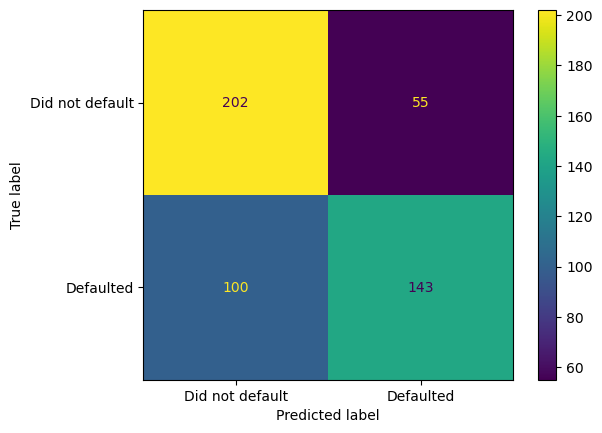

In [122]:
plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test,
                      values_format='d',
                      display_labels=["Did not default", "Defaulted"])

In the confusion matrix, we see that of the **257** people that did not default, **202 (79%)** were correctly classified. And of the **243** people that defaulted, **143 (59%)** were correctly classified. So the **Support Vector Machine** was not awesome. So let's try to improve predictions using **Cross Validation** to optimize the parameters.

----

<a id="optimize-svm"></a>
# Optimize Parameters with Cross Validation and GridSearchCV()

Optimizing a **Support Vector Machine** is all about finding the best value for **gamma**, and, potentially, the regularization parameter, **C**. So let's see if we can find better parameters values using cross validation in hope that we can improve the accuracy with the **Testing Dataset**.

Since we have two parameters to optimize, we will use `GridSearchCV()`. We specify a bunch of potential values for **gamma** and **C**, and `GridSearchCV()` tests all possible combinations of the parameters for us.

In [123]:
param_grid = [
  {'C': [0.5, 1, 10, 100], # NOTE: Values for C must be > 0
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf']},
]
## NOTE: We are includeing C=1 and gamma='scale'
## as possible choices since they are the default values.

optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        scoring='accuracy', ## (accruacy is default scoring) Slightly improved, but hardly!!! C=1, gamma=0.01
        ##scoring='balanced_accuracy', ## Slightly improved, but hardly!!! C=1, gamma=0.01
        ##scoring='f1', ## Terrible!!! C=0.5, gamma=1
        ##scoring='f1_micro', ## Slightly improved, but hardly!!! C=1, gamma=0.01
        ##scoring='f1_macro', ## Same!! C=1, gamma='scale' (these are the same as default values)
        ##scoring='f1_weighted', ## Same!! C=1, gamma='scale' (these are the same as default values)
        ##scoring='roc_auc', ## Terrible!!! C=1, gamma=0.001
        ## For more scoring metics see: 
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        verbose=0 # NOTE: If you want to see what Grid Search is doing, set verbose=2
    )

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


And we see that the ideal value for `C` is **100** , which means we will use regularization, and the ideal value for `gamma` is **0.001**.

----

<a id="draw-svm"></a>
# Building, Evaluating, Drawing and Interpreting the Final Support Vector Machine

Now that we have the ideal values for `C` and `gamma` we can build the final **Support Vector Machine**:

In [124]:
clf_svm = SVC(random_state=42, C=100, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

Now let's draw another confusion matrix to see if the optimized support vector machine does better.

c:\Users\yahri\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


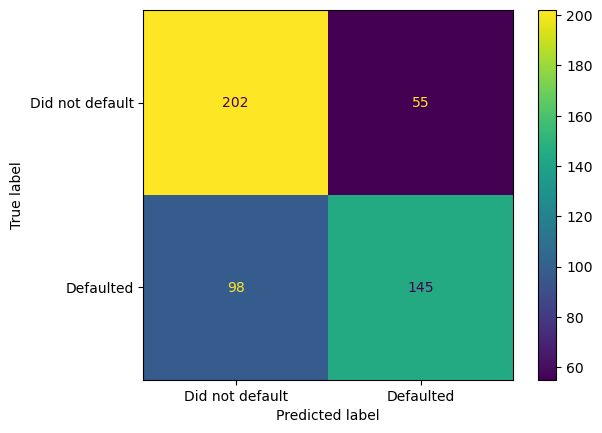

In [125]:
plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test,
                      values_format='d',
                      display_labels=["Did not default", "Defaulted"])

And the results from the *optimized* **Support Vector Machine** are just a little bit better than before. **2** more people were *correctly* classified as defauting.

In other words, the **SVM** was pretty good straight out of the box without much optimization. This makes **SVMs** a great, quick and dirty method for relatively small datasets.

**NOTE:** Although classification with this dataset and an **SVM** is not awesome, it may be better than other methods. We'd have to compare to find out.

The last thing we are going to do is draw a support vector machine decision boundary and discuss how to interpret it.

The first thing we need to do is count the number of columns in **X**:

In [126]:
len(df_downsample.columns)

24

So we see that there are **24** features, or columns, in **X**. 
This is a problem because it would require a 24-dimensional graph, one dimension per feature used to make predictions, to plot the data in its raw form. If we wanted to, we could just pick two features at random to use as x and y-axes on our graph, but instead , we will use **[PCA (Principal Component Analysis)](https://youtu.be/FgakZw6K1QQ)** to combine the **24** features into **2** orthogonal meta-features that we can use as axes for a graph. If you don't already know about PCA, don't sweat it. For now, just know that it is a way to shrink a 24-dimensional graph into a 2-dimensional graph.

However, before we shrink the graph, let's first determine how accurate the shrunken graph will be. If it's relatively accurate, than it makes sense to draw the 2-Dimensional graph. If not, the shrunken graph will not be very useful. We can determine the accuracy of the graph by drawing something called a **scree plot**.

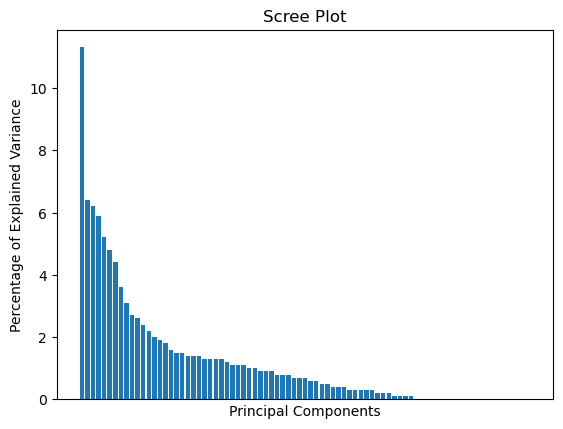

In [127]:
pca = PCA() # NOTE: By default, PCA() centers the data, but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

The scree plot shows that the first principal component, PC1, accounts for a relatively large amount of variation in the raw data, and this means that it will be a good candidate for the x-axis in the 2-dimensional graph. However, PC2 is not much different from PC3 or PC4, which doesn't bode well for dimension reduction. Since we don't have a choice, let's go with it, but don't be suprised if the final graph looks funky.

Now we will draw the PCA graph. **NOTE:** This code is quite technical, but we don't have to type it in and there are comments that explain each step. First, let's optimize an SVM fit to PC1 and PC2.

In [128]:
train_pc1_coords = X_train_pca[:, 0] 
train_pc2_coords = X_train_pca[:, 1]

## NOTE:
## pc1 contains the x-axis coordinates of the data after PCA
## pc2 contains the y-axis coordinates of the data after PCA

## Now center and scale the PCs...
pca_train_scaled = preprocessing.scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

## Now we optimize the SVM fit to the x and y-axis coordinates
## of the data after PCA dimension reduction...
param_grid = [
  {'C': [1, 10, 100, 1000], 
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        scoring='accuracy', # NOTE: The default value for scoring results in worse performance...
        ## For more scoring metics see: 
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        verbose=0 # NOTE: If you want to see what Grid Search is doing, set verbose=2
    )

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


Now that we have the optimal values for `C` and `gamma`, lets draw the graph:

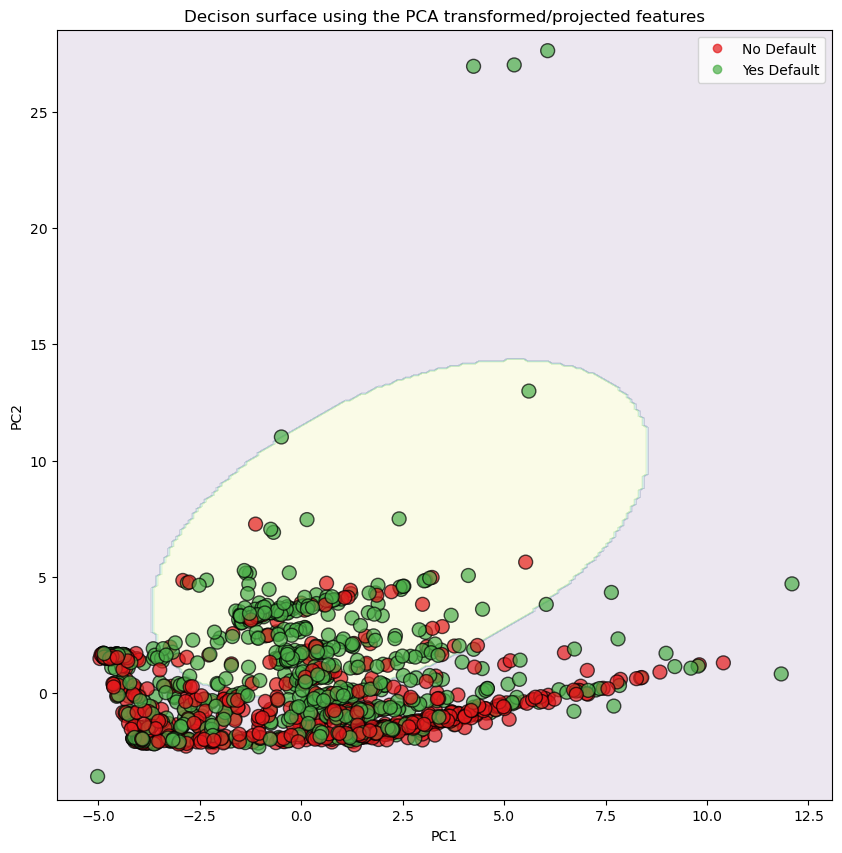

In [129]:
clf_svm = SVC(random_state=42, C=1000, gamma=0.001)
clf_svm.fit(pca_train_scaled, y_train)

## Transform the test dataset with the PCA...
X_test_pca = pca.transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)
test_pc1_coords = X_test_pca[:, 0] 
test_pc2_coords = X_test_pca[:, 1]

## Now create a matrix of points that we can use to show
## the decision regions.
## The matrix will be a little bit larger than the
## transformed PCA points so that we can plot all of
## the PCA points on it without them being on the edge
x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

## now we will classify every point in that 
## matrix with the SVM. Points on one side of the 
## classification boundary will get 0, and points on the other
## side will get 1.
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))
## Right now, Z is just a long array of lots of 0s and 1s, which
## reflect how each point in the mesh was classified.
## We use reshape() so that each classification (0 or 1) corresponds
## to a specific point in the matrix.
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))
## now we will use contourf() to draw a filled contour plot
## using the matrix values and classifications. 
## The contours will be filled according to the 
## predicted classifications (0s and 1s) in Z
ax.contourf(xx, yy, Z, alpha=0.1)

## now create custom colors for the actual data points
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])
## now draw the actual data points - these will
## be colored by their known (not predcited) classifications
## NOTE: setting alpha=0.7 lets us see if we are covering up a point 
# scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_test, 
scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train, 
               cmap=cmap, 
               s=100, 
               edgecolors='k', ## 'k' = black
               alpha=0.7)

## now create a legend
legend = ax.legend(scatter.legend_elements()[0], 
                   scatter.legend_elements()[1],
                    loc="upper right")
legend.get_texts()[0].set_text("No Default")
legend.get_texts()[1].set_text("Yes Default")

## now add axis labels and titles
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decison surface using the PCA transformed/projected features')
# plt.savefig('svm_default.png')
plt.show()

# BAM!!!

The pink part of the graph is the area were all datapoints will be predicted to have *not defaulted*. The yellow part of the graph is the area where all datapoints will be predicted to *have defaulted*. The the dots are datapoints in the training dataset and are color coded by their known classifications: red is for those that did *not default* and green is for those that *defaulted*.

**NOTE:** The results are show the training data, not the testing data and thus, do not match the confusion matrices that we generated. Also, remember that for this picture, we only fit the SVM to the first two principal components instead of all the data, and thus, this is only an approximation of the true classifier. Lastly, because the skree plot showed that PC2 was not very different from PC3 or PC4, this is not a very good approximation.

-----

# In conclusion we...

- **[Loaded the Data From a File](#download-the-data)**

- **[Identified and Dealt with Missing Data](#identify-and-deal-with-missing-data)**

- **[Downsampling Data](#downsample-the-data)**

- **[Formatted the Data for a Support Vector Machine using One-Hot Encoding](#one-hot-encoding)**

- **[Built a Support Vector Machine for Classification](#build-svm)**

- **[Optimized the Support Vector Machine with Cross Validation](#optimize-svm)**

- **[Built, Drew, Interpreted and Evaluated the Final Support Vector Machine](#draw-svm)**

# TRIPLE BAM!!!